In [47]:
##### import matplotlib.pyplot as plt
import os
import keras
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,VGG19, ResNet50, ResNet101, ResNet152, EfficientNetB0,EfficientNetB4, InceptionV3
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout





In [48]:
print(tf.__version__)

2.12.0


In [49]:
path = "/kaggle/input/deepfake-and-real-images/Dataset/"
train_dir = path + 'Train'
test_dir = path + 'Test'
validation_dir = path + 'Validation'

In [50]:
def check_dist(dir):
    print(f"{dir.split('/')[-1]} dataset")
    if os.path.exists(dir):
        real_path = os.path.join(dir,'Real')
        fake_path = os.path.join(dir,'Fake')
        print(f"Real data count: {len(os.listdir(real_path))}")
        print(f"Fake data count: {len(os.listdir(fake_path))}")
    else:
        print("Directory Not Found")
    print()


In [51]:
# check_dist(train_dir)
# check_dist(validation_dir)
# check_dist(test_dir)

In [52]:
%%time
IMG_SIZE = (224, 224)
input_shape=(224,224,3)
batch_size = 128
seed = 7

# ig = ImageDataGenerator()
# igt = ImageDataGenerator(validation_split=0.6)
# igv = ImageDataGenerator(validation_split=0.5)

ig = ImageDataGenerator(rescale=1./255.)
igt = ImageDataGenerator(rescale=1./255.,validation_split=0.6)
igv = ImageDataGenerator(rescale=1./255.,validation_split=0.5)
train_flow = igt.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=seed
)

# ig1 = ImageDataGenerator(rescale=1./255.)
valid_flow = igv.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=seed
)

test_flow = ig.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    shuffle = False,
    class_mode='categorical',
    seed=seed
)

train_flow.class_indices

Found 56002 images belonging to 2 classes.
Found 19715 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
CPU times: user 3.42 s, sys: 1.97 s, total: 5.39 s
Wall time: 34.2 s


{'Fake': 0, 'Real': 1}

### Model Training

In [53]:
model_checkpoint = ModelCheckpoint(filepath='/kaggle/working/efficient_128_v0.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

class PredictionCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(valid_flow[0][0])
        y_test = valid_flow[0][1]
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)
        cfm = confusion_matrix(y_test_labels, y_pred_labels)
        print(cfm)        

In [54]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
for i, layer in enumerate(base_model.layers):
    print(i,layer)
# base_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
0 <keras.engine.input_layer.InputLayer object at 0x7d91afc67d60>
1 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7d91afc668f0>
2 <keras.layers.convolutional.conv2d.Conv2D object at 0x7d91ccb096c0>
3 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7d91afca6770>
4 <keras.layers.core.activation.Activation object at 0x7d91ccb0a860>
5 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7d91afca4760>
6 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7d91afca4970>
7 <keras.layers.convolutional.conv2d.Conv2D object at 0x7d91afca74c0>
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7d91afca7b50>
9 <keras.layers.core.activation.Activation object at 0x7d91afca5600>
10 <keras.layers.convolutional.conv2d.Conv2D object at 0x7d910f63e2c0>
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7d910f63f6

In [55]:

def build_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    
    for layer in base_model.layers[:150]:
        layer.trainable = False

    model = Sequential([base_model,
                        layers.GlobalAveragePooling2D(),
                        layers.Dropout(0.4),
                        layers.Dense(1024,activation='relu'),
                        layers.Dropout(0.4),
                        layers.Dense(2, activation='softmax')
                        ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                 )
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                        

In [56]:
%%time

history1 = model.fit(train_flow,
    epochs = 15,
    validation_data =valid_flow,
    callbacks=[model_checkpoint, early_stopping]
)

with open('/kaggle/working/history_efficient_128.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/15
438/438 [==============================] - 589s 1s/step - loss: 0.5593 - accuracy: 0.7462 - val_loss: 0.7354 - val_accuracy: 0.5925
Epoch 2/15
438/438 [==============================] - 264s 602ms/step - loss: 0.4168 - accuracy: 0.8114 - val_loss: 0.6756 - val_accuracy: 0.6993
Epoch 3/15
438/438 [==============================] - 266s 607ms/step - loss: 0.3874 - accuracy: 0.8275 - val_loss: 5.2459 - val_accuracy: 0.5021
Epoch 4/15
438/438 [==============================] - 266s 607ms/step - loss: 0.3695 - accuracy: 0.8348 - val_loss: 1.1211 - val_accuracy: 0.6428
Epoch 5/15
438/438 [==============================] - 267s 608ms/step - loss: 0.3559 - accuracy: 0.8413 - val_loss: 2.3799 - val_accuracy: 0.5114
Epoch 6/15
438/438 [==============================] - 267s 608ms/step - loss: 0.3525 - accuracy: 0.8449 - val_loss: 0.3863 - val_accuracy: 0.8269
Epoch 7/15
438/438 [==============================] - 265s 605ms/step - loss: 0.3388 - accuracy: 0.8500 - val_loss: 1.1085 - va

NameError: name 'history' is not defined

In [57]:
model.evaluate(test_flow)

10905/10905 [==============================] - 116s 11ms/step - loss: 0.7258 - accuracy: 0.7483


[0.7257922887802124, 0.7482805848121643]

In [73]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(test_flow)
y_true = test_flow.classes
y_pred_classes = np.argmax(y_pred, axis=1)

class_labels = list(test_flow.class_indices.keys())

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

10905/10905 [==============================] - 88s 8ms/step
Confusion Matrix:
[[3282 2210]
 [ 535 4878]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.86      0.60      0.71      5492
        Real       0.69      0.90      0.78      5413

    accuracy                           0.75     10905
   macro avg       0.77      0.75      0.74     10905
weighted avg       0.77      0.75      0.74     10905



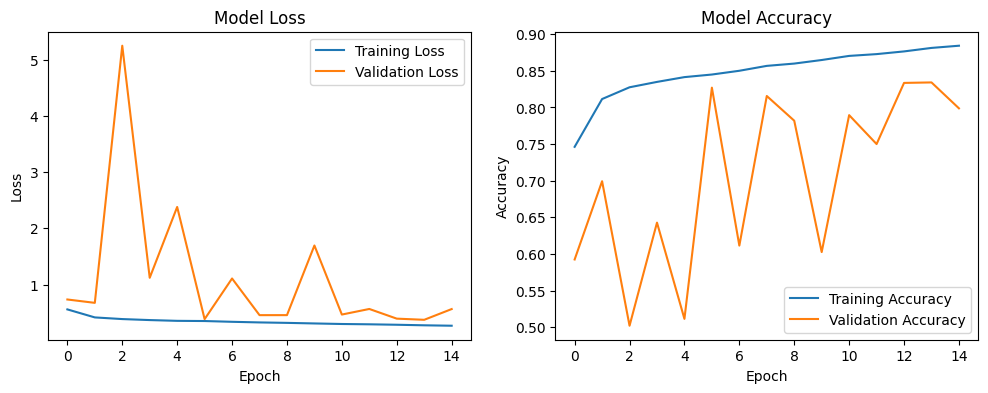

In [59]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 [==============================] - 0s 26ms/step
Actual class is fake, predicted class is fake


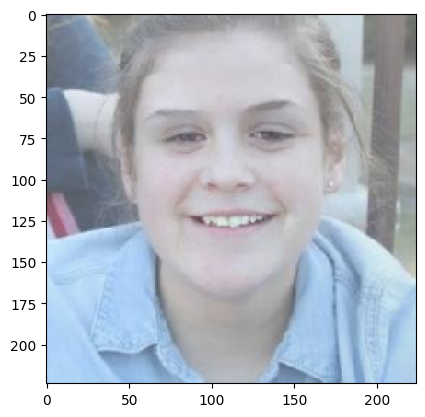

In [98]:
import matplotlib.pyplot as plt
img,label = test_flow[10];
label_ = label.argmax(axis=1)

res = model.predict(img)

class_ = res.argmax(axis=1)
if class_[0] == 0:
    if label_ == 0:
        print("Actual class is fake, predicted class is fake")
    else:
        print("Actual class is real, predicted class is fake")
else:
    if label_ == 0:
        print("Actual class is fake, predicted class is real")
    else:
        print("Actual class is real, predicted class is real")
        
plt.imshow(img[0])
plt.show()